# Les nouveaux modes d’accès aux données: le format parquet et les

données sur le cloud

<p class="badges">

<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/NLP/05a_s3.ipynb" class="github"><i class="fab fa-github"></i></a>
<a href="https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/NLP/05a_s3.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter" alt="Download"></a>
<a href="https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/NLP/05a_s3.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter" alt="nbviewer"></a>
<a href="https://datalab.sspcloud.fr/launcher/ide/jupyter-python?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABNLP%2005a_s3%C2%BB&security.allowlist.enabled=false" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&amp;color=yellow?logo=Python" alt="Onyxia"></a><br>
<a href="https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath={binder_path}" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=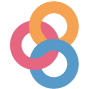" alt="Binder"></a>
<a href="http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/NLP/05a_s3.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
<a href="https://github.dev/linogaliana/python-datascientist/notebooks/course/NLP/05a_s3.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/static/v1?logo=visualstudiocode&label=&message=Open%20in%20Visual%20Studio%20Code&labelColor=2c2c32&color=007acc&logoColor=007acc" alt="githubdev"></a>

</p>

</p>

Ce chapitre est une introduction à la question
du stockage des données et aux innovations
récentes dans ce domaine. L’objectif
est d’abord de présenter les avantages
du format `Parquet` et la manière dont
on peut utiliser les
librairies [`pyarrow`](https://arrow.apache.org/docs/python/index.html)
ou [`duckdb`](https://duckdb.org/docs/api/python/overview.html) pour traiter
de manière efficace des données volumineuses
au format `Parquet`. Ensuite, on présentera
la manière dont ce format `parquet` s’intègre
bien avec des systèmes de stockage *cloud*,
qui tendent à devenir la norme dans le monde
de la *data science*.

# Elements de contexte

## Principe du stockage de la donnée

Pour comprendre les apports du format `Parquet`, il est nécessaire
de faire un détour pour comprendre la manière dont une information
est stockée et accessible à un langage de traitement de la donnée.

Il existe deux approches dans le monde du stockage de la donnée.
La première est celle de la **base de données relationnelle**. La seconde est le
principe du **fichier**.
La différence entre les deux est dans la manière dont l’accès aux
données est organisé.

## Les fichiers

Dans un fichier, les données sont organisées selon un certain format et
le logiciel de traitement de la donnée va aller chercher et structurer
l’information en fonction de ce format. Par exemple, dans un fichier
`.csv`, les différentes informations seront stockées au même niveau
avec un caractère pour les séparer (la virgule `,` dans les `.csv` anglosaxons, le point virgule dans les `.csv` français, la tabulation dans les `.tsv`). Le fichier suivant

``` raw
nom ; profession 
Astérix ; 
Obélix ; Tailleur de menhir ;
Assurancetourix ; Barde
```

sera ainsi organisé naturellement sous forme tabulée par `Python`

,nom,profession
0,Astérix,
1,Obélix,Tailleur de menhir
2,Assurancetourix,Barde


A propos des fichiers de ce type, on parle de **fichiers plats** car
les enregistrements relatifs à une observation sont stockés ensemble,
sans hiérarchie.

Certains formats de données vont permettre d’organiser les informations
de manière différente. Par exemple, le format `JSON` va
hiérarchiser différemment la même information `{=html} <a name="cite_note-1"></a>1. [^](#cite_ref-1)`

``` raw
[
  {
    "nom": "Astérix"
  },
  {
    "nom": "Obélix",
    "profession": "Tailleur de menhir"
  },
  {
    "nom": "Assurancetourix",
    "profession": "Barde"
  }
]
```

<div class="alert alert-warning" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #ffc10780;">
<h3 class="alert-heading"><i class="fa fa-lightbulb-o"></i> Hint </h3>

La différence entre le CSV et le format `JSON` va au-delà d’un simple “formattage” des données.

Par sa nature non tabulaire, le format JSON permet des mises à jour beaucoup plus facile de la donnée dans les entrepôts de données.

Par exemple, un site web qui collecte de nouvelles données n’aura pas à mettre à jour l’ensemble de ses enregistrements antérieurs
pour stocker la nouvelle donnée (par exemple pour indiquer que pour tel ou tel client cette donnée n’a pas été collectée)
mais pourra la stocker dans
un nouvel item. Ce sera à l’outil de requête (`Python` ou un autre outil)
de créer une relation entre les enregistrements stockés à des endroits
différents.

Ce type d’approche flexible est l’un des fondements de l’approche `NoSQL`,
sur laquelle nous allons revenir, qui a permis l’émergence de technologies au coeur de l’écosystème actuel du *big-data* comme `Hadoop` ou `ElasticSearch`.

</div>

Cette fois, quand on n’a pas d’information, on ne se retrouve pas avec nos deux séparateurs accolés (cf. la ligne *“Astérix”*) mais l’information
n’est tout simplement pas collectée.

<div class="alert alert-info" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #007bff80;">
<h3 class="alert-heading"><i class="fa fa-comment"></i> Note</h3>

Il se peut très bien que l’information sur une observation soit disséminée
dans plusieurs fichiers dont les formats diffèrent.

Par exemple, dans le domaine des données géographiques,
lorsqu’une donnée est disponible sous format de fichier(s), elle peut l’être de deux manières!

-   Soit la donnée est stockée dans un seul fichier qui mélange contours géographiques et valeurs attributaires
    (la valeur associée à cette observation géographique, par exemple le taux d’abstention). Ce principe est celui du `geojson`.
-   Soit la donnée est stockée dans plusieurs fichiers qui sont spécialisés: un fichier va stocker les contours géographiques,
    l’autre les données attributaires et d’autres fichiers des informations annexes (comme le système de projection). Ce principe est celui du `shapefile`.
    C’est alors le logiciel qui requête
    les données (`Python` par exemple) qui saura où aller chercher l’information
    dans les différents fichiers et associer celle-ci de manière cohérente.

</div>

Un concept supplémentaire dans le monde du fichier est celui du **file system**. Le *file system* est
le système de localisation et de nommage des fichiers.
Pour simplifier, le *file system* est la manière dont votre ordinateur saura
retrouver, dans son système de stockage, les bits présents dans tel ou tel fichier
appartenant à tel ou tel dossier.

## Les bases de données

La logique des bases de données est différente. Elle est plus systémique.
Un système de gestion de base de données (*Database Management System*)
est un logiciel qui gère à la fois le stockage d’un ensemble de données reliée,
permet de mettre à jour celle-ci (ajout ou suppression d’informations, modification
des caractéristiques d’une table…)
et qui gère également
les modalités d’accès à la donnée (type de requête, utilisateurs
ayant les droits en lecture ou en écriture…).

La relation entre les entités présentes dans une base de données
prend généralement la forme d’un **schéma en étoile**. Une base va centraliser
les informations disponibles qui seront ensuite détaillées dans des tables
dédiées.

![](https://www.databricks.com/wp-content/uploads/2022/04/star-schema-erd.png)
Source: [La documentation `Databricks` sur le schéma en étoile](https://www.databricks.com/fr/glossary/star-schema)

Le logiciel associé à la base de données fera ensuite le lien
entre ces tables à partir de requêtes `SQL`. L’un des logiciels les plus efficaces dans ce domaine
est [`PostgreSQL`](https://www.postgresql.org/). `Python` est tout à fait
utilisable pour passer une requête SQL à un gestionnaire de base de données.
Les packages [`sqlalchemy`](https://www.sqlalchemy.org/) et [`psycopg2`](https://www.psycopg.org/docs/)
peuvent servir à utiliser `PostgreSQL` pour requêter une
base de donnée ou la mettre à jour.

La logique de la base de données est donc très différente de celle du fichier.
Ces derniers sont beaucoup plus légers pour plusieurs raisons.
D’abord, parce qu’ils sont moins adhérents à
un logiciel gestionnaire. Là où le fichier ne nécessite, pour la gestion,
qu’un *file system*, installé par défaut sur
tout système d’exploitation, une base de données va nécessiter un
logiciel spécialisé. L’inconvénient de l’approche fichier, sous sa forme
standard, est qu’elle
ne permet pas une gestion fine des droits d’accès et amène généralement à une
duplication de la donnée pour éviter que la source initiale soit
ré-écrite (involontairement ou de manière intentionnelle par un utilisateur malveillant).
Résoudre ce problème est l’une des
innovations des systèmes *cloud*, sur lesquelles nous reviendrons en évoquant le
système `S3`.
Un deuxième inconvénient de l’approche base de données par
rapport à l’approche fichier, pour un utilisateur de `Python`,
est que les premiers nécessitent l’intermédiation du logiciel de gestion
de base de données là où, dans le second cas, on va se contenter d’une
librairie, donc un système beaucoup plus léger,
qui sait comment transformer la donnée brute en `DataFrame`.
Pour ces raisons, entre autres, les bases de données sont donc moins à la
mode dans l’écosystème récent de la *data-science* que les fichiers.

# Le format `parquet`

Le format `CSV` a rencontré un grand succès par sa simplicité: il
est lisible par un humain (un bloc-note suffit pour l’ouvrir et
apercevoir les premières lignes), sa nature plate lui permet
de bien correspondre au concept de données tabulées sans hiérarchie
qui peuvent être rapidement valorisées, il est universel (il n’est
pas adhérent à un logiciel). Cependant, le CSV présente
plusieurs inconvénients qui justifient l’émergence d’un format
concurrent:

-   le CSV est un format **lourd** car les informations ne sont pas compressées
    (ce qui le rend lisible facilement depuis un bloc-note) mais aussi
    parce que toutes les données sont stockées de la même manière.
    C’est la
    librairie faisant l’import qui va essayer d’optimiser le typage des données
    pour trouver le typage qui utilise le moins de mémoire possible sans
    altération de l’information. En effet, si `pandas` détermine qu’une colonne
    présente les valeurs `6 ; 5 ; 0`, il va privilégier l’utilisation du type
    `int` au type `double` qui sera lui même préféré au type `object` (objets
    de type données textuelles). Cependant, pour faire cela, `pandas` va devoir
    scanner un nombre suffisant de valeurs, ce qui demande du temps et expose
    à des erreurs (en se fondant sur trop peu de valeurs, on peut se tromper
    de typage) ;
-   le stockage étant **orienté ligne**,
    accéder à une information donnée dans un `CSV` implique
    de le lire le fichier en entier, sélectionner la ou les colonnes
    d’intérêt et ensuite les lignes désirées. Par exemple, si on désire
    connaître uniquement la profession de la deuxième ligne dans l’exemple
    plus haut :point_up:, un algorithme de recherche devra:
    prendre le fichier, déterminer que la profession est la deuxième colonne,
    et ensuite aller chercher la deuxième ligne dans cette colonne. Si
    on désire accéder à un sous-ensemble de lignes dont les indices
    sont connus, le `CSV` est intéressant. Cependant,
    si on désire accéder à un sous-ensemble
    de colonnes dans un fichier (ce qui est un cas d’usage plus fréquent
    pour les *data-scientists*), alors le `CSV` n’est pas le format le plus
    approprié ;
-   mettre à jour la donnée est coûteux car cela implique de réécrire
    l’ensemble du fichier. Par exemple, si après une première
    analyse de la donnée,
    on désire ajouter une colonne, on ne peut accoler ces nouvelles informations
    à celles déjà existantes, il est nécessaire de réécrire l’ensemble
    du fichier. Pour reprendre l’exemple de nos gaulois préférés, si on veut
    ajouter une colonne `cheveux` entre les deux déjà existantes,
    il faudra changer totalement le fichier:

``` raw
"""
nom ; cheveux ; profession
Astérix; blond; ; 
Obélix; roux; Tailleur de menhir
Assurancetourix; blond; Barde
"""
```

<div class="alert alert-info" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #007bff80;">
<h3 class="alert-heading"><i class="fa fa-comment"></i> Note</h3>

La plupart des logiciels d’analyse de données proposent
un format de fichier pour sauvegarder des bases de données. On
peut citer le `.pickle` (`Python`), le `.rda` ou `.RData` (`R`),
le `.dta` (`Stata`) ou le `.sas7bdat` (`SAS`). L’utilisation
de ces formats est problématique car cela revient à se lier
les mains pour l’analyse ultérieure des données, surtout
lorsqu’il s’agit d’un format propriétaire (comme avec
`SAS` ou `Stata`). Par exemple, `Python` ne
sait pas nativement lire un `.sas7bdat`. Il existe des librairies
pour le faire (notamment `Pandas`) mais le format
étant propriétaire, les développeurs de la librairie ont dû tâtonner et
on n’est ainsi jamais assuré qu’il n’y ait pas d’altération de la donnée.

Malgré tous les inconvénients du `.csv` listés plus haut, il présente
l’immense avantage, par rapport à ces formats, de l’universalité.
Il vaut ainsi mieux privilégier un `.csv` à ces formats pour le stockage
de la donnée. Ceci dit, comme vise à le montrer ce chapitre, il vaut
mieux privilégier le format `parquet` au `CSV`.

</div>

Pour répondre à ces limites du `CSV`, le format `parquet`,
qui est un [projet open-source `Apache`](https://apache.org/), a émergé.
La première différence entre le format `parquet` et le `CSV` est
que le premier repose sur un **stockage orienté colonne** là où
le second est orienté ligne. Pour comprendre la différence, voici un
exemple issu du [blog d’upsolver](https://www.upsolver.com/blog/apache-parquet-why-use):

![](https://www.upsolver.com/wp-content/uploads/2020/05/Screen-Shot-2020-05-26-at-17.52.58.png)

Dans notre exemple précédent, cela donnera une information prenant
la forme suivante (ignorez l’élément `pyarrow.Table`, nous
reviendrons dessus) :

pyarrow.Table
nom : string
profession: string
----
nom : [["Astérix ","Obélix ","Assurancetourix "]]
profession: [["","Tailleur de menhir","Barde"]]

Pour reprendre l’exemple fil rouge :point_up:, il sera ainsi beaucoup plus
facile de récupérer la deuxième ligne de la colonne `profession`:
on ne considère que le vecteur `profession` et on récupère la deuxième
valeur.
Le requêtage d’échantillon de données ne nécessite donc pas l’import de
l’ensemble des données. A cela s’ajoute des fonctionnalités supplémentaires
des librairies d’import de données parquet (par exemple `pyarrow` ou `spark`)
qui vont faciliter des recherches complexes basées, par exemple, sur des
requêtes de type `SQL`, ou permettant l’utilisation de données plus volumineuses que la RAM.

Le format `parquet` présente d’autres avantages par rapport au
`CSV`:

-   Le format `parquet` est (très) compressé, ce qui réduit la volumétrie
    des données sur disque ;
-   Des métadonnées, notamment le typage des variables, sont stockées en complément dans le fichier.
    Cette partie, nommée le *footer* du fichier `parquet`, permet que l’import des données soit
    optimisé sans risque d’altération de celle-ci. Pour un producteur de données, c’est une manière
    d’assurer la qualité des données. Par exemple, un fournisseur de
    données de type code-barre sera
    certain que les données `000012` ne seront pas considérées identiques à un code-barre `12`.
-   Il est possible de partitionner un jeu de données en fonction de différents niveaux (par
    exemple des niveaux géographiques) en une arborescence de fichiers `parquet`. Cela
    permet de travailler sur un échantillon pour facilement passer à l’échelle ensuite.
    Par exemple, une structure partitionnée, empruntée
    à la [documentation `Spark`](https://spark.apache.org/docs/latest/sql-data-sources-parquet.html#partition-discovery)
    peut prendre la forme suivante:

``` raw
path
└── to
    └── table
        ├── gender=male
        │   ├── ...
        │   │
        │   ├── country=US
        │   │   └── data.parquet
        │   ├── country=CN
        │   │   └── data.parquet
        │   └── ...
        └── gender=female
            ├── ...
            │
            ├── country=US
            │   └── data.parquet
            ├── country=CN
            │   └── data.parquet
            └── ...
```

Qu’on lise un ou plusieurs fichiers, on finira avec le schéma suivant:

``` raw
root
|-- name: string (nullable = true)
|-- age: long (nullable = true)
|-- gender: string (nullable = true)
|-- country: string (nullable = true)
```

Ces différents avantages expliquent le succès du format `parquet` dans le monde du
*big-data*. Le paragraphe suivant, extrait du [post d’upsolver]() déjà cité,
résume bien l’intérêt:

> Complex data such as logs and event streams would need to be represented as a table with hundreds or thousands of columns, and many millions of rows. Storing this table in a row based format such as CSV would mean:
>
> -   Queries will take longer to run since more data needs to be scanned, rather than only querying the subset of columns we need to answer a query (which typically requires aggregating based on dimension or category)
> -   Storage will be more costly since CSVs are not compressed as efficiently as Parquet

Cependant, **`Parquet` ne devrait pas intéresser que les producteurs ou utilisateurs de données *big-data***.
C’est l’ensemble
des producteurs de données qui bénéficient des fonctionalités
de `Parquet`.

Pour en savoir plus sur `Arrow`,
des éléments supplémentaires sur `Parquet` sont disponibles sur ce très bon
post de blog d’[upsolver](https://www.upsolver.com/blog/apache-parquet-why-use)
et [sur la page officielle du projet `Parquet`](https://parquet.apache.org/).

## Lire un `parquet` en `Python`: la librairie `pyarrow`

La librairie `pyarrow` permet la lecture et l’écriture
de fichiers `parquet` avec `Python`<a name="cite_ref-3"></a>[<sup>\[3\]</sup>](#cite_note-3). Elle repose
sur un type particulier de *dataframe*, le `pyarrow.Table`
qui peut être utilisé en substitut ou en complément
du `DataFrame`
de `pandas`. Il est recommandé de régulièrement
consulter la documentation officielle de `pyarrow`
concernant [la lecture et écriture de fichiers](https://arrow.apache.org/docs/python/parquet.html) et celle relative
aux [manipulations de données](https://arrow.apache.org/cookbook/py/data.html).

Elle permet aussi la lecture et l’écriture
de `.csv`.

Pour illustrer les fonctionalités de `pyarrow`,
repartons de notre CSV initial que nous allons
enrichir d’une nouvelle variable numérique
et que nous
allons
convertir en objet `pyarrow` avant de l’écrire au format `parquet`:

In [4]:
import pandas as pd
from io import StringIO 
import pyarrow as pa
import pyarrow.parquet as pq

s = """
nom;cheveux;profession
Astérix;blond;
Obélix;roux;Tailleur de menhir
Assurancetourix;blond;Barde
"""

source = StringIO(s)

df = pd.read_csv(source, sep = ";", index_col=False)
df["taille"] = [155, 190, 175]
table = pa.Table.from_pandas(df)

table

pq.write_table(table, 'example.parquet')

<div class="alert alert-warning" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #ffc10780;">
<h3 class="alert-heading"><i class="fa fa-lightbulb-o"></i> Hint </h3>

L’utilisation des noms `pa` pour `pyarrow` et `pq` pour
`pyarrow.parquet` est une convention communautaire
qu’il est recommandé de suivre.

</div>

Pour importer et traiter ces données, on peut conserver
les données sous le format `pyarrow.Table`
ou transformer en `pandas.DataFrame`. La deuxième
option est plus lente mais présente l’avantage
de permettre ensuite d’appliquer toutes les
manipulations offertes par l’écosystème
`pandas` qui est généralement mieux connu que
celui d’`Arrow`.

Supposons qu’on ne s’intéresse qu’à la taille et à la couleur
de cheveux de nos gaulois.
Il n’est pas nécessaire d’importer l’ensemble de la base, cela
ferait perdre du temps pour rien. On appelle
cette approche le **`column pruning`** qui consiste à
ne parcourir, dans le fichier, que les colonnes qui nous
intéressent. Du fait du stockage orienté colonne du `parquet`,
il suffit de ne considérer que les blocs qui nous
intéressent (alors qu’avec un CSV il faudrait scanner tout
le fichier avant de pouvoir éliminer certaines colonnes).
Ce principe du `column pruning` se matérialise avec
l’argument `columns` dans `parquet`.

Ensuite, avec `pyarrow`, on pourra utiliser `pyarrow.compute` pour
effectuer des opérations directement sur une table
`Arrow` :

In [5]:
import pyarrow.compute as pc

table = pq.read_table('example.parquet', columns=['taille', 'cheveux'])

table.group_by("cheveux").aggregate([("taille", "mean")])

La manière équivalente de procéder en passant
par l’intermédiaire de `pandas` est

In [6]:
table = pq.read_table('example.parquet', columns=['taille', 'cheveux'])

table.to_pandas().groupby("cheveux")["taille"].mean()

cheveux
blond    165.0
roux     190.0
Name: taille, dtype: float64

Ici, comme les données sont peu volumineuses, deux des
avantages du `parquet` par rapport
au `CSV` (données moins
volumineuses et vitesse de l’import)
ne s’appliquent pas vraiment.

<div class="alert alert-info" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #007bff80;">
<h3 class="alert-heading"><i class="fa fa-comment"></i> Note</h3>

Un autre principe d’optimisation de la performance qui est
au coeur de la librairie `Arrow` est le `filter pushdown`
(ou `predicate pushdown`).

Quand on exécute un filtre de sélection de ligne
juste après avoir chargé un jeu de données,
`Arrow` va essayer de le mettre en oeuvre lors de l’étape de lecture
et non après. Autrement dit, `Arrow` va modifier le plan
d’exécution pour pousser le filtre en amont de la séquence d’exécution
afin de ne pas essayer de lire les lignes inutiles.

</div>

# Le système de stockage `S3`

Si les fichiers `parquet` sont une
solution avantageuse pour
les *data-scientists*, ils ne résolvent
pas tous les inconvénients de
l’approche fichier.
En particulier, la question de la
duplication des données pour la mise
à disposition sécurisée des sources
n’est pas résolue. Pour que
l’utilisateur `B` n’altère pas les
données de l’utilisateur `A`, il est nécessaire
qu’ils travaillent sur deux fichiers
différents, dont l’un peut être une copie
de l’autre.

# Les données sur le *cloud*

La mise à disposition de données dans
les systèmes de stockage *cloud* est
une réponse à ce problème.
Les *data lake* qui se sont développés dans les
institutions et entreprises utilisatrices de données

Le principe d’un stockage cloud
est le même que celui d’une
`Dropbox` ou d’un `Drive` mais adapté à
l’analyse de données. Un utilisateur de données
accède à un fichier stocké sur un serveur distant
*comme s’il* était dans son *file system* local<a name="cite_ref-4"></a>[<sup>\[4\]</sup>](#cite_note-4).
Donc, du point de vue de l’utilisateur `Python`,
il n’y a pas de différence fondamentale. Cependant,
les données ne sont pas hebergées dans un dossier
local (par exemple `Mes Documents/monsuperfichier`)
mais sur un serveur distant auqgituel l’utilisateur
de `Python` accède à travers un échange réseau.

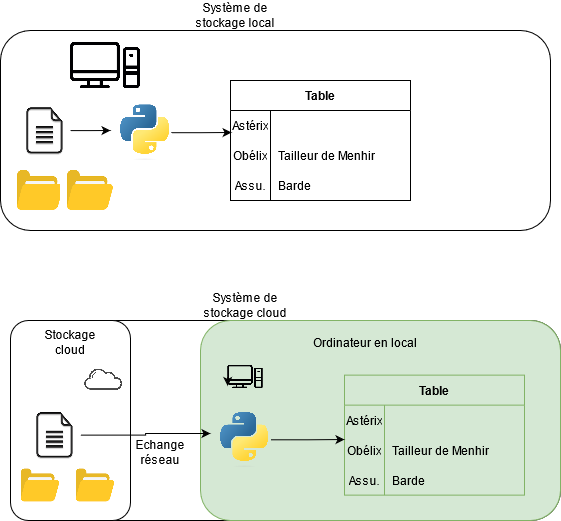

Dans l’univers du *cloud*, la hiérarchisation des données
dans des dossiers et des fichiers bien rangés
est d’ailleurs moins
importante que dans le monde du *file system* local.
Lorsque vous essayez de retrouver un fichier dans
votre arborescence de fichiers, vous utilisez parfois
la barre de recherche de votre explorateur de fichiers,
avec des résultats mitigés<a name="cite_ref-4"></a>[<sup>\[4\]</sup>](#cite_note-4). Dans le monde du *cloud*,
les fichiers sont parfois accumulés de manière plus
chaotique car les outils de recherche sont plus
efficaces<a name="cite_ref-4"></a>[<sup>\[4\]</sup>](#cite_note-4).

D’ailleurs, les générations n’ayant connu nativement
que ce type de stockage ne sont pas familiarisées
au concept de *file system* et préfèrent
payer le temps de recherche. Voir
[cet article](https://futurism.com/the-byte/gen-z-kids-file-systems)
sur le sujet.

En ce qui concerne la sécurité des données,
la gestion des droits de lecture et écriture peut être
fine: on peut autoriser certains utilisateurs uniquement
à la lecture, d’autres peuvent avoir les droits
d’écriture pour modifier les données. Cela permet
de concilier les avantages des bases de données (la sécurisation
des données) avec ceux des fichiers.

## Qu’est-ce que le système de stockage `S3` ?

Dans les entreprises et administrations,
un nombre croissant de données sont
disponibles depuis un système de stockage
nommé `S3`.
Le système `S3` (*Simple Storage System*) est un système de stockage développé
par Amazon et qui est maintenant devenu une référence pour le stockage en ligne.
Il s’agit d’une architecture à la fois
sécurisée (données cryptées, accès restreints) et performante.

Le concept central du système S3 est le ***bucket***.
Un *bucket* est un espace (privé ou partagé) où on peut stocker une
arborescence de fichiers. Pour accéder aux fichiers figurant
dans un *bucket* privé, il faut des jetons d’accès (l’équivalent d’un mot de passe)
reconnus par le serveur de stockage. On peut alors lire et écrire dans le *bucket*.

<div class="alert alert-info" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #007bff80;">
<h3 class="alert-heading"><i class="fa fa-comment"></i> Note</h3>

Les exemples suivants seront réplicables pour les utilisateurs de la plateforme
SSP-cloud

<a href="https://datalab.sspcloud.fr/launcher/ide/jupyter-python?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABNLP%2005a_s3%C2%BB&security.allowlist.enabled=false" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&amp;color=yellow?logo=Python" alt="Onyxia"></a><br>

Ils peuvent également l’être pour des utilisateurs ayant un
accès à AWS, il suffit de changer l’URL du `endpoint`
présenté ci-dessous.

</div>

## Comment faire avec Python ?

### Les librairies principales

L’interaction entre ce système distant de fichiers et une session locale de Python
est possible grâce à des API. Les deux principales librairies sont les suivantes:

-   [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html), une librairie créée et maintenue par Amazon ;
-   [s3fs](https://s3fs.readthedocs.io/en/latest/), une librairie qui permet d’interagir avec les fichiers stockés à l’instar d’un filesystem classique.

La librairie `pyarrow` que nous avons déjà présenté permet également
de traiter des données stockées sur le *cloud* comme si elles
étaient sur le serveur local. C’est extrêmement pratique
et permet de fiabiliser la lecture ou l’écriture de fichiers
dans une architecture *cloud*.
Un exemple, assez court, est disponible
[dans la documentation officielle](https://arrow.apache.org/docs/python/filesystems.html#s3)

Il existe également d’autres librairies permettant de gérer
des *pipelines* de données (chapitre à venir) de manière
quasi indifférente entre une architecture locale et une architecture
*cloud*. Parmi celles-ci, nous présenterons quelques exemples
avec `snakemake`.
En arrière-plan, `snakemake`
va utiliser `boto3` pour communiquer avec le système
de stockage.

Enfin, selon le même principe du *comme si* les données
étaient en local, il existe l’outil en ligne de commande
`mc` ([`Minio Client`](https://docs.min.io/docs/minio-client-complete-guide.html)) qui permet de gérer par des lignes
de commande Linux les dépôts distants comme s’ils étaient
locaux.

Toutes ces librairies offrent la possibilité de se connecter depuis `Python`,
à un dépôt de fichiers distant, de lister les fichiers disponibles dans un
*bucket*, d’en télécharger un ou plusieurs ou de faire de l’*upload*
Nous allons présenter quelques unes des opérations les plus fréquentes,
en mode *cheatsheet*.

## Connexion à un bucket

Par la suite, on va utiliser des alias pour les trois valeurs suivantes, qui servent
à s’authentifier.

``` python
key_id = 'MY_KEY_ID'
access_key = 'MY_ACCESS_KEY'
token = "MY_TOKEN"
```

Ces valeurs peuvent être également disponibles dans
les variables d’environnement de `Python`. Comme il s’agit d’une information
d’authentification personnelle, il ne faut pas stocker les vraies valeurs de ces
variables dans un projet, sous peine de partager des traits d’identité sans le
vouloir lors d’un partage de code.

<details><summary><code>boto3</code> 👇</summary>

Avec `boto3`, on créé d’abord un client puis on exécute des requêtes dessus.
Pour initialiser un client, il suffit, en supposant que l’url du dépôt S3 est
`"https://minio.lab.sspcloud.fr"`, de faire:

``` python
import boto3
s3 = boto3.client("s3",endpoint_url = "https://minio.lab.sspcloud.fr")
```

</details>

<details><summary><code>S3FS</code> 👇</summary>

La logique est identique avec `s3fs`.

Si on a des jetons d’accès à jour et dans les variables d’environnement
adéquates:

``` python
import s3fs
fs = s3fs.S3FileSystem(
  client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'})
```

</details>

<details><summary><code>Arrow</code> 👇</summary>

La logique d’`Arrow` est proche de celle de `s3fs`. Seuls les noms
d’arguments changent

Si on a des jetons d’accès à jour et dans les variables d’environnement
adéquates:

``` python
from pyarrow import fs
s3 = fs.S3FileSystem(endpoint_override="http://"+"minio.lab.sspcloud.fr")
```

</details>

<details><summary><code>Snakemake</code> 👇</summary>

La logique de `Snakemake` est, quant à elle,
plus proche de celle de `boto3`. Seuls les noms
d’arguments changent

Si on a des jetons d’accès à jour et dans les variables d’environnement
adéquates:

``` python
from snakemake.remote.S3 import RemoteProvider as S3RemoteProvider
S3 = S3RemoteProvider(host = "https://" + os.getenv('AWS_S3_ENDPOINT'))
```

</details>

Il se peut que la connexion à ce stade soit refusée (`HTTP error 403`).
Cela peut provenir
d’une erreur dans l’URL utilisé. Cependant, cela reflète plus généralement
des paramètres d’authentification erronés.

<details><summary><code>boto3</code> 👇</summary>

Les paramètres d’authentification sont des arguments supplémentaires:

``` python
import boto3
s3 = boto3.client("s3",endpoint_url = "https://minio.lab.sspcloud.fr",
                  aws_access_key_id=key_id, 
                  aws_secret_access_key=access_key, 
                  aws_session_token = token)
```

</details>

<details><summary><code>S3FS</code> 👇</summary>

La logique est la même, seuls les noms d’arguments diffèrent

``` python
import s3fs
fs = s3fs.S3FileSystem(
  client_kwargs={'endpoint_url': 'https://'+'minio.lab.sspcloud.fr'},
  key = key_id, secret = access_key,
  token = token)
```

</details>

<details><summary><code>Arrow</code> 👇</summary>

Tout est en argument cette fois:

``` python
from pyarrow import fs

s3 = fs.S3FileSystem(
    access_key = key_id,
    secret_key = access_key,
    session_token = token,
    endpoint_override = 'https://'+'minio.lab.sspcloud.fr',
    scheme = "https"
    )
```

</details>

<details><summary><code>Snakemake</code> 👇</summary>

La logique est la même, seuls les noms d’arguments diffèrent

``` python
from snakemake.remote.S3 import RemoteProvider as S3RemoteProvider
S3 = S3RemoteProvider(host = "https://" + os.getenv('AWS_S3_ENDPOINT'), access_key_id=key_id, secret_access_key=access_key)
```

</details>

<div class="alert alert-info" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #007bff80;">
<h3 class="alert-heading"><i class="fa fa-comment"></i> Note</h3>

Dans le SSP-cloud,
lorsque l’initialisation du service `Jupyter` du SSP-cloud est récente
(moins de 12 heures), il est possible d’utiliser
automatiquement les jetons stockés automatiquement à la création du dépôt.

Si on désire accéder aux données du SSP-cloud depuis une session python du
datalab (service VSCode, Jupyter…),
il faut remplacer l’url par `http://minio.lab.sspcloud.fr`

</div>

## Lister les fichiers

S’il n’y a pas d’erreur à ce stade, c’est que la connexion est bien effective.
Pour le vérifier, on peut essayer de faire la liste des fichiers disponibles
dans un `bucket` auquel on désire accéder.

Par exemple, on peut vouloir
tester l’accès aux bases `FILOSOFI` (données de revenu localisées disponibles
sur <https://www.insee.fr>) au sein du bucket `donnees-insee`.

<details><summary><code>boto3</code> 👇</summary>

Pour cela,
la méthode `list_objects` offre toutes les options nécessaires:

`python {hl_lines=["3-4"]} import boto3 s3 = boto3.client("s3",endpoint_url = "https://minio.lab.sspcloud.fr") for key in s3.list_objects(Bucket='donnees-insee', Prefix='diffusion/FILOSOFI')['Contents']:     print(key['Key'])`

</details>

<details><summary><code>S3FS</code> 👇</summary>

Pour lister les fichiers, c’est la méthode `ls` (celle-ci ne liste pas par
défaut les fichiers de manière récursive comme `boto3`):

`python {hl_lines=[4]} import s3fs fs = s3fs.S3FileSystem(   client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'}) fs.ls("donnees-insee/diffusion")`

</details>

<details><summary><code>Arrow</code> 👇</summary>

`python {hl_lines=[3]} from pyarrow import fs s3 = fs.S3FileSystem(endpoint_override='https://'+'minio.lab.sspcloud.fr') s3.get_file_info(fs.FileSelector('donnees-insee/diffusion', recursive=True))`

</details>

<details><summary><code>mc</code> 👇</summary>

``` shell
mc ls -r
```

</details>

## Télécharger un fichier depuis `S3` pour l’enregistrer en local

Cette méthode n’est en général pas recommandée car, comme on va le voir
par la suite, il est possible de lire à la volée des fichiers. Cependant,
télécharger un fichier depuis le *cloud* pour l’écrire sur le disque
local peut parfois être utile (par exemple, lorsqu’il est nécessaire
de dézipper un fichier).

<details><summary><code>boto3</code> 👇</summary>

On utilise cette fois la méthode `download_file`

`python {hl_lines=[3]} import boto3 s3 = boto3.client("s3",endpoint_url = "https://minio.lab.sspcloud.fr") s3.download_file('donnees-insee', "diffusion/FILOSOFI/2014/FILOSOFI_COM.csv", 'data.csv')`

</details>

<details><summary><code>S3FS</code> 👇</summary>

`python {hl_lines=[4]} import s3fs fs = s3fs.S3FileSystem(   client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'}) fs.download('donnees-insee/diffusion/FILOSOFI/2014/FILOSOFI_COM.csv','test.csv')`

</details>

<details><summary><code>Snakemake</code> 👇</summary>

``` python
from snakemake.remote.S3 import RemoteProvider as S3RemoteProvider
S3 = S3RemoteProvider(host = "https://" + os.getenv('AWS_S3_ENDPOINT'))
bucket = "mon-bucket"

rule ma_super_regle_s3:
    input:
        fichier = S3.remote(f'{bucket}/moninput.csv')
    output:
        fichier='mon_dossier_local/monoutput.csv'
    run:
        shell("cp {input[0]} {output[0]}")
```

</details>

<details><summary><code>mc</code> 👇</summary>

``` python
mc cp "donnees-insee/FILOSOFI/2014/FILOSOFI_COM.csv" 'data.csv'
```

</details>

## Lire un fichier directement

La méthode précédente n’est pas optimale. En effet, l’un des intérêts des API
est qu’on peut traiter un fichier sur `S3` comme s’il s’agissait d’un fichier
sur son PC. Cela est d’ailleurs une manière plus sécurisée de procéder puisqu’on
lit les données à la volée, sans les écrire dans un filesystem local.

<details><summary><code>boto3</code> 👇</summary>

`python {hl_lines=["3-4"]} import boto3 s3 = boto3.client("s3",endpoint_url = "https://minio.lab.sspcloud.fr") obj = s3.get_object(Bucket='donnees-insee', Key="diffusion/FILOSOFI/2014/FILOSOFI_COM.csv") df = pd.read_csv(obj['Body'], sep = ";") df.head(2)`

</details>

<details><summary><code>S3FS</code> 👇</summary>

Le code suivant devrait permettre d’effectuer la même opération avec `s3fs`

\`\`\`python {hl_lines=\[“5-7”\]}
import pandas as pd
import s3fs
fs = s3fs.S3FileSystem(
client_kwargs={‘endpoint_url’: ‘https://minio.lab.sspcloud.fr’})
df = pd.read_csv(fs.open(‘{}/{}’.format(‘donnees-insee’, “diffusion/FILOSOFI/2014/FILOSOFI_COM.csv”),
mode=‘rb’), sep = “;”
)

df.head(2)




    ```{=html}
    </details>

<details><summary><code>Snakemake</code> 👇</summary>

``` python
from snakemake.remote.S3 import RemoteProvider as S3RemoteProvider
S3 = S3RemoteProvider(host = "https://" + os.getenv('AWS_S3_ENDPOINT'))
bucket = "mon-bucket"

rule ma_super_regle_s3:
    input:
        fichier = S3.remote(f'{bucket}/moninput.csv')
    run:
        import pandas as pd
        df = pd.read_csv(input.fichier)
        # PLUS D'OPERATIONS
```

</details>

<details><summary><code>Arrow</code> 👇</summary>

`Arrow` est une librairie qui permet de lire des `CSV`.
Il est néanmoins
beaucoup plus pratique d’utiliser le format `parquet` avec `arrow`.
Dans un premier temps, on configure le *filesystem* avec les
fonctionalités d’`Arrow` (cf. précédemment).

``` python
from pyarrow import fs

s3 = fs.S3FileSystem(endpoint_override='http://'+'minio.lab.sspcloud.fr')
```

Pour lire un csv, on fera:

\`\`\`python {hl_lines=\[“6-7”\]}
from pyarrow import fs
from pyarrow import csv

s3 = fs.S3FileSystem(endpoint_override=‘https://’+‘minio.lab.sspcloud.fr’)

with s3.open_input_file(“donnees-insee/diffusion/FILOSOFI/2014/FILOSOFI_COM.csv”) as file:
df = csv.read_csv(file, parse_options=csv.ParseOptions(delimiter=“;”)).to_pandas()


    Pour un fichier au format parquet, la démarche est plus simple grâce à l'argument
    `filesystem` dans `pyarrow.parquet.ParquetDataset` :

    ```python {hl_lines=[5]}
    import pyarrow.parquet as pq

    #bucket = ""
    #parquet_file=""
    df = pq.ParquetDataset(f'{bucket}/{parquet_file}', filesystem=s3).read_pandas().to_pandas()

</details>

## Uploader un fichier

<details><summary><code>boto3</code> 👇</summary>

``` python
s3.upload_file(file_name, bucket, object_name)
```

</details>

<details><summary><code>S3FS</code> 👇</summary>

``` python
fs.put(filepath, f"{bucket}/{object_name}", recursive=True)
```

</details>

<details><summary><code>Arrow</code> 👇</summary>

Supposons que `df` soit un `pd.DataFrame`
Dans un système local, on convertirait
en table `Arrow` puis on écrirait en `parquet`
([voir la documentation officielle](https://arrow.apache.org/docs/python/parquet.html#reading-and-writing-single-files)).
Quand on est sur un système `S3`, il s’agit seulement d’ajouter
notre connexion à `S3` dans l’argument `filesystem`
([voir la page sur ce sujet dans la documentation Arrow](https://arrow.apache.org/docs/python/filesystems.html#filesystem-s3))

``` python
import pyarrow as pa
import pyarrow.parquet as pq

table = pa.Table.from_pandas(df)
pq.write_table(table, f"{bucket}/{path}", filesystem=s3)
```

</details>

<details><summary><code>Snakemake</code> 👇</summary>

``` python
from snakemake.remote.S3 import RemoteProvider as S3RemoteProvider
S3 = S3RemoteProvider(host = "https://" + os.getenv('AWS_S3_ENDPOINT'))
bucket = "mon-bucket"

rule ma_super_regle_s3:
    input:
        fichier='mon_dossier_local/moninput.csv'
    output:
        fichier=S3.remote(f'{bucket}/monoutput.csv')
    run:
        shell("cp output.fichier input.fichier")
```

</details>

<details><summary><code>mc</code> 👇</summary>

``` python
mc cp 'data.csv' "MONBUCKET/monoutput.csv"
```

</details>

## Pour aller plus loin

-   [La documentation sur MinIO du SSPCloud](https://docs.sspcloud.fr/onyxia-guide/stockage-de-donnees)